In [1]:
%load_ext lab_black

In [2]:
# Loading all necessary libraries
import numpy as np
import pandas as pd
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from dateutil import parser
from collections import defaultdict
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
import spacy
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
import random
import unidecode
import emoji
import json
import gc
import os
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
from sklearn.decomposition import LatentDirichletAllocation as LDA

In [3]:
%matplotlib inline

sp = spacy.load("it_core_news_lg")

### Load Input Data

In [4]:
TYPE_PAGE_LIST = ["politicians"]
TYPE_SOCIAL_LIST = ["facebook"]  # ["facebook", "instagram"]
COUNTRY_PAGE_LIST = ["italy"]

DATA_PATH = "data/"
OUTPUT_PATH = "output/"

COLUMNS_TYPES_FB = {}
COLUMNS_TYPES_IG = {}

In [5]:
MONTHS_2019 = {"dec": 12}
MONTHS_2020 = {
    "jan": 1,
    "feb": 2,
    "mar": 3,
    "apr": 4,
    "may": 5,
    "jun": 6,
    "jul": 7,
    "aug": 8,
}
df_map = {}
df_months_map = {
    "dec": {},
    "jan": {},
    "feb": {},
    "mar": {},
    "apr": {},
    "may": {},
    "jun": {},
    "jul": {},
    "aug": {},
}
df_specific_party_map = {
    "dec": {},
    "jan": {},
    "feb": {},
    "mar": {},
    "apr": {},
    "may": {},
    "jun": {},
    "jul": {},
    "aug": {},
}
df_pol_party_frequency_migration_map = {
    "dec": {},
    "jan": {},
    "feb": {},
    "mar": {},
    "apr": {},
    "may": {},
    "jun": {},
    "jul": {},
    "aug": {},
}
lists_months_map = {
    "dec": {},
    "jan": {},
    "feb": {},
    "mar": {},
    "apr": {},
    "may": {},
    "jun": {},
    "jul": {},
    "aug": {},
}
figures = {
    "dec": [],
    "jan": [],
    "feb": [],
    "mar": [],
    "apr": [],
    "may": [],
    "jun": [],
    "jul": [],
    "aug": [],
}

In [6]:
with open(DATA_PATH + "politician_party_map.json") as json_file:
    politicians_party_map = json.load(json_file)

with open(DATA_PATH + "keywords_month.json") as json_file:
    keywords_month_map = json.load(json_file)

with open(DATA_PATH + "risk_keywords_month.json") as json_file:
    risk_keywords_month_map = json.load(json_file)

In [7]:
for type_page in TYPE_PAGE_LIST:
    for type_social in TYPE_SOCIAL_LIST:
        for country_page in COUNTRY_PAGE_LIST:
            name_df = "_".join((type_page, type_social, country_page))
            df_map[name_df] = pd.read_csv(DATA_PATH + name_df + ".csv", header=0,)
            df_map[name_df]["Created"] = df_map[name_df]["Created"].apply(
                lambda x: parser.parse(x)
            )
            if type_social == "instagram":
                df_map[name_df]["Description"] = df_map[name_df]["Description"].fillna(
                    value=""
                )
            else:
                df_map[name_df]["Message"] = df_map[name_df]["Message"].fillna(value="")

/Users/silvio/opt/anaconda3/envs/ricerca/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (29) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/silvio/opt/anaconda3/envs/ricerca/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname EDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)
/Users/silvio/opt/anaconda3/envs/ricerca/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname EST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


In [8]:
# df_map["politicians_facebook_italy"].head()

### Create DFs Map per Month

In [9]:
for name_df, df in df_map.items():
    df_months_map[list(MONTHS_2019.keys())[0]][name_df] = df_map[name_df][
        (df_map[name_df]["Created"] >= "2019-12-01")
        & (df_map[name_df]["Created"] < "2020-01-01")
    ].copy()

for name_df, df in df_map.items():
    for month in MONTHS_2020.keys():
        df_months_map[month][name_df] = df_map[name_df][
            (df_map[name_df]["Created"] >= "2020-{}-01".format(MONTHS_2020[month]))
            & (df_map[name_df]["Created"] < "2020-{}-01".format(MONTHS_2020[month] + 1))
        ].copy()

In [10]:
del df_map
gc.collect()

1003

### Cleaning functions

In [11]:
all_stopwords = sp.Defaults.stop_words
with open("stopwords_italian.json") as json_file:
    italian_stopwords = json.load(json_file)
all_stopwords |= set(italian_stopwords["stopwords"])

In [12]:
def remove_emoji(text):
    return emoji.get_emoji_regexp().sub(u"", text)

In [13]:
def clean_text(text):
    text = remove_emoji(text)
    # text = unidecode.unidecode(text)
    text = text.lower()
    text = text.strip()
    text = re.sub("#\S+:", "", text)
    text = re.sub("# \S+ :", "", text)
    text = re.sub("#\S+ :", "", text)
    text = re.sub("# \S+:", "", text)
    text = re.sub("#\S+", "", text)
    text = re.sub("legaonline.it\S+", "", text)
    text = re.sub("[,\.!?#]", "", text)
    text = re.sub("\s+", " ", text)
    text = (
        text.replace("http", "")
        .replace("www", "")
        .replace("shortener", "")
        .replace("ref", "")
        .replace("matteo salvini", "salvini")
        .replace("user", "")
        .replace("legaonline.it/iostoconsalvini", "")
    )
    text = re.sub("\s+", " ", text)
    # stop_words = set(stopwords.words("italian"))
    text_tokens = word_tokenize(text)
    tokens_without_sw = [word for word in text_tokens if not word in all_stopwords]

    res = " ".join(tokens_without_sw)
    return res

### Create map divided by couple politician + party and by month

In [14]:
for month, df_map_month in df_months_map.items():
    for df_name, df_data in df_map_month.items():
        for pol, party in politicians_party_map.items():
            if len(party) > 0:
                complete_name = (
                    pol.lower().replace(" - ", " ").replace(" ", "_")
                    + "__"
                    + party.lower().replace(" - ", " ").replace(" ", "_")
                )
                df_specific_party_map[month][complete_name] = df_data.loc[
                    df_data["Page Name"].isin([pol, party])
                ].copy()
            else:
                complete_name = pol.lower().replace(" - ", " ").replace(" ", "_")
                df_specific_party_map[month][complete_name] = df_data.loc[
                    df_data["Page Name"].isin([pol])
                ].copy()
            df_specific_party_map[month][complete_name][
                "Message"
            ] = df_specific_party_map[month][complete_name]["Message"].apply(
                lambda x: clean_text(x)
            )
            df_specific_party_map[month][complete_name] = df_specific_party_map[month][
                complete_name
            ].reset_index()

In [15]:
gc.collect()

1477

### PLOT OF: Frequency of migration related posts per politician + party (together as one) throughout time 

In [16]:
def avg_engagement(df_):
    engagements = []
    interactions_list = []
    for index, row in df_.iterrows():
        followers = row["Likes at Posting"]
        interactions = (
            row["Likes"]
            + row["Comments"]
            + row["Shares"]
            + row["Love"]
            + row["Wow"]
            + row["Haha"]
            + row["Sad"]
            + row["Angry"]
            + row["Care"]
        )
        # print(row)
        # print(followers)
        # print(interactions)
        engagements.append((interactions / followers) * 100)
        interactions_list.append(interactions)
        mean_engagement = sum(engagements) / len(engagements)
        mean_interactions = sum(interactions_list) / len(interactions_list)
    return round(mean_engagement, 2), round(mean_interactions, 2)

In [17]:
for month, df_map_month in df_specific_party_map.items():
    lists_months_map[month] = {
        "page_names": [],
        "freq": [],
        "avg_engagement": [],
        "avg_interactions": [],
    }
    for df_name, df_data in df_map_month.items():
        words = "|".join(w for w in keywords_month_map[month])
        migration_posts = (
            df_data[df_data["Message"].str.contains(words)].copy().reset_index()
        )
        freq = len(migration_posts)
        # print(month,df_name,freq)
        if freq > 0:
            mean_engagement, mean_interactions = avg_engagement(migration_posts)
        else:
            mean_engagement = 0
            mean_interactions = 0
        df_pol_party_frequency_migration_map[month][df_name] = {
            "freq": freq,
            "avg_engagement": mean_engagement,
            "avg_interactions": mean_interactions,
        }
        lists_months_map[month]["page_names"].append(df_name)
        lists_months_map[month]["freq"].append(freq)
        lists_months_map[month]["avg_engagement"].append(mean_engagement)
        lists_months_map[month]["avg_interactions"].append(mean_interactions)

In [18]:
df_pol_party_frequency_migration_map["mar"]

{'matteo_salvini__lega_salvini_premier': {'freq': 115,
  'avg_engagement': 0.58,
  'avg_interactions': 12442.17},
 'luigi_di_maio__movimento_5_stelle': {'freq': 128,
  'avg_engagement': 0.18,
  'avg_interactions': 3395.87},
 'silvio_berlusconi__forza_italia': {'freq': 9,
  'avg_engagement': 0.29,
  'avg_interactions': 1857.56},
 'nicola_zingaretti__partito_democratico': {'freq': 58,
  'avg_engagement': 0.63,
  'avg_interactions': 2064.19},
 'emma_bonino__più_europa': {'freq': 7,
  'avg_engagement': 0.48,
  'avg_interactions': 636.14},
 "giorgia_meloni__fratelli_d'italia": {'freq': 21,
  'avg_engagement': 1.21,
  'avg_interactions': 16723.14},
 'matteo_renzi__italia_viva': {'freq': 49,
  'avg_engagement': 0.96,
  'avg_interactions': 1962.51},
 'nicola_fratoianni': {'freq': 4,
  'avg_engagement': 1.33,
  'avg_interactions': 1268.25},
 'giuseppe_conte': {'freq': 1,
  'avg_engagement': 2.89,
  'avg_interactions': 66190.0}}

In [19]:
df_pol_party_frequency_migration_map["dec"]

{'matteo_salvini__lega_salvini_premier': {'freq': 158,
  'avg_engagement': 0.52,
  'avg_interactions': 10954.45},
 'luigi_di_maio__movimento_5_stelle': {'freq': 88,
  'avg_engagement': 0.27,
  'avg_interactions': 4659.03},
 'silvio_berlusconi__forza_italia': {'freq': 11,
  'avg_engagement': 0.34,
  'avg_interactions': 941.45},
 'nicola_zingaretti__partito_democratico': {'freq': 26,
  'avg_engagement': 0.31,
  'avg_interactions': 963.15},
 'emma_bonino__più_europa': {'freq': 8,
  'avg_engagement': 0.34,
  'avg_interactions': 430.25},
 "giorgia_meloni__fratelli_d'italia": {'freq': 22,
  'avg_engagement': 0.96,
  'avg_interactions': 12346.73},
 'matteo_renzi__italia_viva': {'freq': 27,
  'avg_engagement': 1.23,
  'avg_interactions': 3232.67},
 'nicola_fratoianni': {'freq': 7,
  'avg_engagement': 1.62,
  'avg_interactions': 1511.29},
 'giuseppe_conte': {'freq': 5,
  'avg_engagement': 1.25,
  'avg_interactions': 13254.6}}

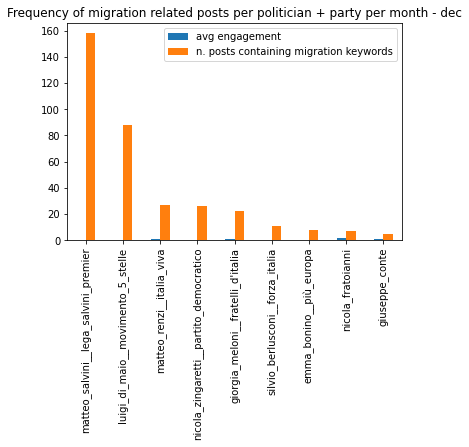

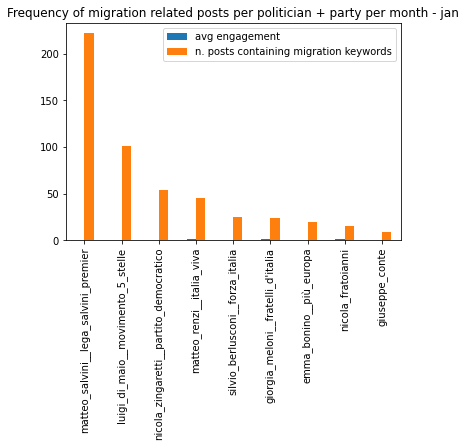

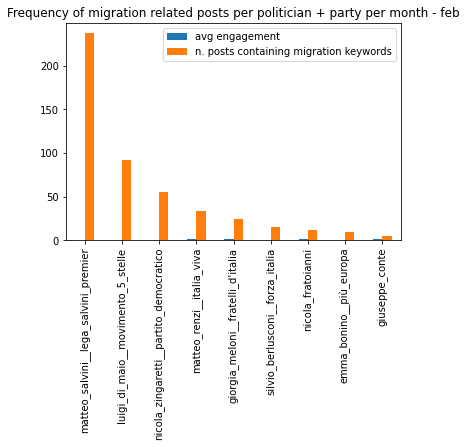

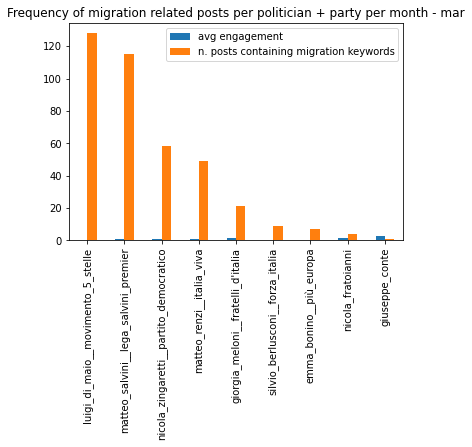

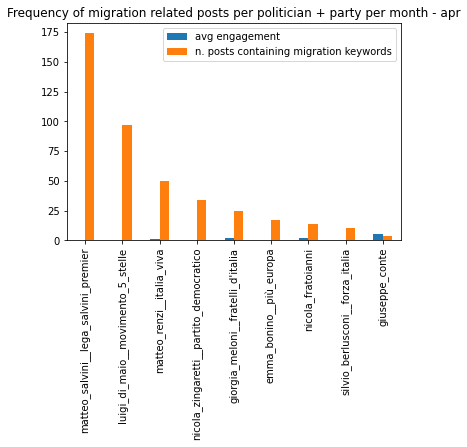

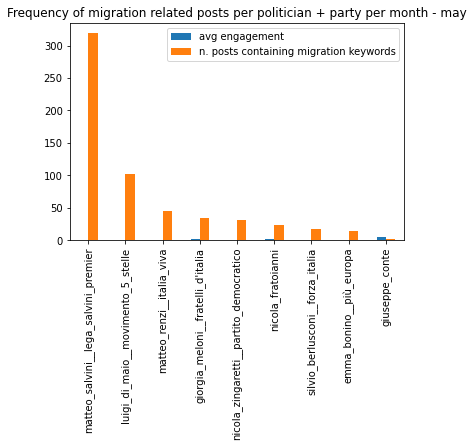

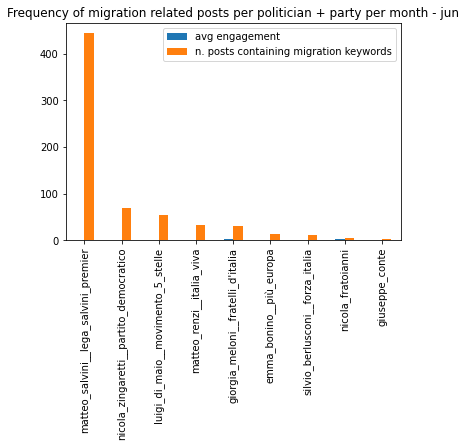

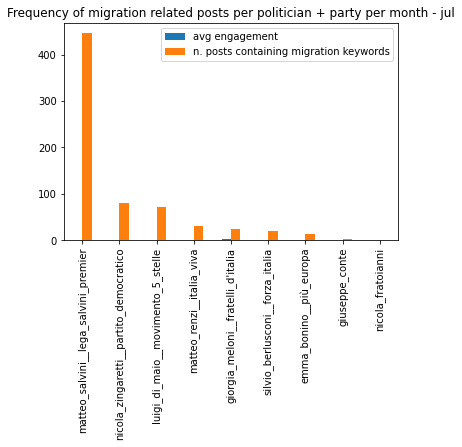

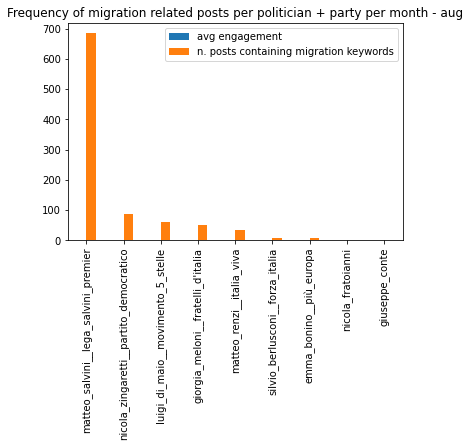

In [22]:
for month, lists_map in lists_months_map.items():
    pages_names = lists_map["page_names"]
    engagements = lists_map["avg_engagement"]
    freq = lists_map["freq"]
    # mean_interactions = lists_map["avg_interactions"]
    df = pd.DataFrame(
        {
            "avg engagement": engagements,
            "n. posts containing migration keywords": freq,
            # "avg interactions": mean_interactions,
        },
        index=pages_names,
    )
    if len(df) > 0:
        ax = df.sort_values(
            "n. posts containing migration keywords", ascending=False
        ).plot(
            kind="bar",
            title="Frequency of migration related posts per politician + party per month - {}".format(
                month
            ),
            rot=90,
        )
        figures[month].append(ax)

### Generate Final PDFs

In [21]:
for month, plots in figures.items():
    if month == "dec":
        name_file = OUTPUT_PATH + "frequency_migration_by_month/2019_{}.pdf".format(
            month
        )
    else:
        name_file = OUTPUT_PATH + "frequency_migration_by_month/2020_{}.pdf".format(
            month
        )
    pdf = matplotlib.backends.backend_pdf.PdfPages(name_file)
    for fig in plots:  ## will open an empty extra figure :(
        fig = fig.get_figure()
        # print(type(fig))
        pdf.savefig(fig, bbox_inches="tight")
    pdf.close()

## Top-10 Performing Posts per Page

In [ ]:
def get_best_posts(df, social_type):
    if social_type == "instagram":
        df["interactions"] = df["Likes"] + df["Comments"]
        df = df.sort_values(
            by=["interactions", "Overperforming Score"], ascending=False
        ).iloc[0:10]
    else:
        df["interactions"] = (
            df["Likes"]
            + df["Comments"]
            + df["Shares"]
            + df["Love"]
            + df["Haha"]
            + df["Wow"]
            + df["Sad"]
            + df["Care"]
            + df["Angry"]
        )
        df = df.sort_values(
            by=["interactions", "Overperforming Score"], ascending=False
        ).iloc[0:10]
    return df

In [ ]:
df_ig_list = []
df_fb_list = []
for df_name, df_data in df_map.items():
    social_type = df_name.split("_")[1]
    if social_type == "instagram":
        grouped = df_data.groupby(["Account"])
    else:
        grouped = df_data.groupby(["Page Name"])
    for name, group in grouped:
        df_copy = group.copy()
        df = get_best_posts(df_copy, social_type)
        if social_type == "instagram":
            df_ig_list.append(df)
        else:
            df_fb_list.append(df)
    # print(df.head())

In [ ]:
# result_ig = pd.concat(df_ig_list).reset_index()
result_fb = pd.concat(df_fb_list).reset_index()

# result_ig.to_csv("top_10_posts_ig.csv")
result_fb.to_csv("top_10_posts_fb.csv")